In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
from matplotlib import colormaps #type: ignore

In [2]:
cmp = 'viridis'
include_viridis = False
sv = False
dpi = 500
transparent = False
task = 'alpaca'
lr=2e-5
batch = 2
method = 'lora'
layers = 0

pth = f'/rscratch/tpang/kinshuk/RpMKin/LlaMAft/Plots/{task}'
if sv:
    print(os.getcwd())
    pth = os.path.join(os.getcwd(), pth)
    Path(pth).mkdir(parents=True, exist_ok=True)
    print(pth)

In [3]:
base_path = (
        f"/rscratch/tpang/kinshuk/RpMKin/llama_ft/LlaMAft/output/{task}/lr_{lr}/batch_{batch}/{method}/layers_{layers}"
    )
path = os.path.join(base_path, "finetune.npy")
baseline = np.load(path, allow_pickle=True).item()

In [4]:
dictionary = {'train_loss': []}
dictionary['train_loss'].append(baseline['train_loss'])
dictionary['train_loss'] = np.array(dictionary['train_loss']) # type: ignore


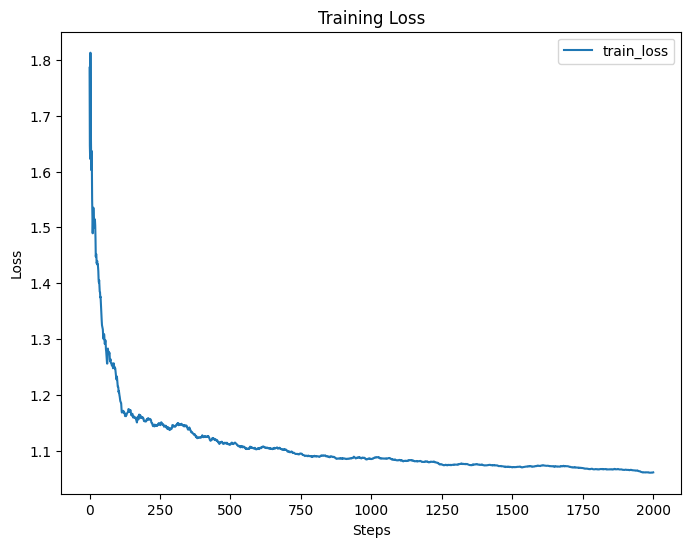

In [5]:
# Plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(dictionary['train_loss'][0], label='train_loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()